['M2_X1.tif', 'M2_X2.tif', 'M2_X3.tif', 'M2_X4.tif', 'M2_X5.tif', 'M2_X6.tif', 'M2_X7.tif', 'M2_X8.tif', 'M2_X9.tif', 'M2_X10.tif', 'M2_X11.tif', 'M2_X12.tif', 'M2_X13.tif', 'M2_X14.tif', 'M2_X15.tif', 'M2_X16.tif', 'M2_X17.tif', 'M2_X18.tif', 'M2_X19.tif', 'M2_X20.tif']
C:\Users\User\z\Desktop\WUT\Diplomka\DATA\Images\2090 nm\H6\(1) 50-1000ns\M2_X18.tif
C:\Users\User\z\Desktop\WUT\Diplomka\DATA\Images\2090 nm\ref x4 Cu,H0-H2,H6 - 50-1000ns\REFx4_X20.tif
511 685 255


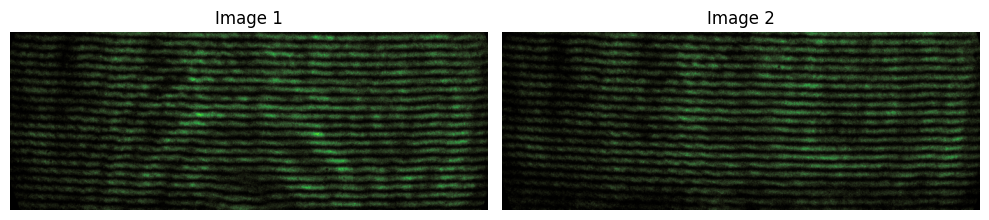

In [12]:
import sys
import os
# Go up two levels from current path (from src/ to project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))  
sys.path.append(project_root)
import global_utils
import global_constants
import constants
import global_functions_im
import utils
import functions_image_crop
import functions_phase_shift
import functions_abel
import functions_electron_density_analysis

import matplotlib.pyplot as plt
import tifffile as tiff  # Loads .tiff as a NumPy array
import numpy as np  # low level image manipulation (matrix)
import cmasher as cmr  # extra colormaps
# -------------- constants load ----------------------------
p = constants.p
exclude_radius_peaks = constants.exclude_radius_peaks
smooth_spectra_sigma = constants.smooth_spectra_sigma
# mask param (do not touch)
a = constants.a  # x-axis mask
# b = spectr_peak_distance  # y-axis mask
inner_radius_mask = constants.inner_radius_mask
# x0 = cols // 2 # middle of an image -> if needed change here
dr = constants.dr
reg = constants.reg
sigma_abel = constants.sigma_abel
crop_edge_artefacts = constants.crop_edge_artefacts
# -----------------------------------------------------
peak_name = 'minus1'
px_crop = 40
mask_sigma = 5
y_peak_shift = True
shift_val = 20
base_crop = 15
# -----------------------------------------------------

path_img_files = global_constants.dir_2090_H6_1
path_ref_files = global_constants.dir_2090_x4_50ns

files_img = global_utils.get_file_names(path_img_files)
files_img = global_utils.filter_by_M_exact(
    files_img,
    exact = 2
)
print(files_img)
img_path = os.path.join(path_img_files, files_img[17]) # 2
files_ref = global_utils.get_file_names(path_ref_files)
ref_path = os.path.join(path_ref_files, files_ref[1]) # 
print(img_path)
print(ref_path)
# ---- LOAD DATA ----
img = tiff.imread(img_path)
ref = tiff.imread(ref_path)

# ---- CROP DATA ----
# detect edges
sx, wid, hei = functions_image_crop.compute_crop_params(img, px_crop)
print(sx, wid, hei)
crop_img = functions_image_crop.crop_from_center(img, sx, wid, hei)
crop_ref = functions_image_crop.crop_from_center(ref, sx, wid, hei)

    # ---- PADDING IMAGE ----
padded_img = np.pad(crop_img, pad_width=p, mode='constant')  # constant, wrap, symmetric
padded_ref = np.pad(crop_ref, pad_width=p, mode='constant')  # constant, wrap, symmetric
global_functions_im.plot_two_images(crop_img,crop_ref)

    # ---- FOURIER TRANSFORM ----
    # isolate the -1st-order peak and get its phase map
spectr_peaks = functions_phase_shift.find_fourier_peaks(padded_img, exclude_radius=exclude_radius_peaks,
                                                        smooth_sigma=smooth_spectra_sigma)
    # extract the first coordinate of ‘center’ and ‘plus1’
if peak_name == 'plus1':
        y_peak = int(spectr_peaks['plus1'][0])
        x_peak = int(spectr_peaks['plus1'][1])
elif peak_name == 'minus1':
        y_peak = int(spectr_peaks['minus1'][0])
        x_peak = int(spectr_peaks['minus1'][1])
else:
    raise ValueError(f"Unknown peak_name: {peak_name!r}")
y_peak_c = int(spectr_peaks['center'][0])
x_peak_c = int(spectr_peaks['center'][1])

spectr_peak_distance = abs(y_peak_c - y_peak) - 1  # distance from center = b value of the mask
b = spectr_peak_distance  # second (elliptical mask) axis

    # shift mask from the diffraction order (optional)
if y_peak_shift:
        if peak_name == 'plus1':
            shift_val = -shift_val  # shift mask up (-)#num
        elif peak_name == 'minus1':
            shift_val = shift_val  # down (+)#num
        y_peak = y_peak + shift_val

phase_map_im = functions_phase_shift.compute_phase_from_padded(
        img_padded=padded_img,
        order=peak_name,
        exclude_radius=exclude_radius_peaks,  # to find peaks outside
        smooth_sigma=smooth_spectra_sigma,  # smooth spectrum to find peaks better
        a_div=a,
        b_div=b,
        mask_sigma=mask_sigma,  # gauss filter mask
        pad=p  # padding crop after computation
)
phase_map_ref = functions_phase_shift.compute_phase_from_padded(
        img_padded=padded_ref,
        order=peak_name,
        exclude_radius=exclude_radius_peaks,
        smooth_sigma=smooth_spectra_sigma,
        a_div=a,
        b_div=b,
        mask_sigma=mask_sigma,
        pad=p
)

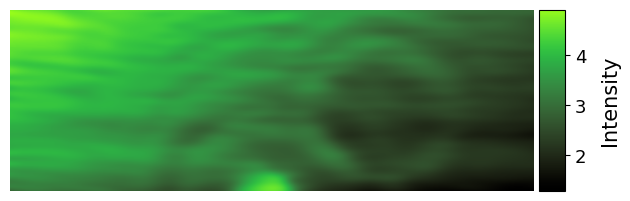

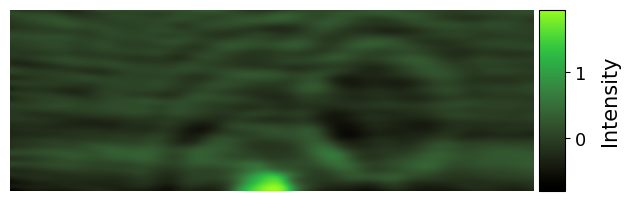

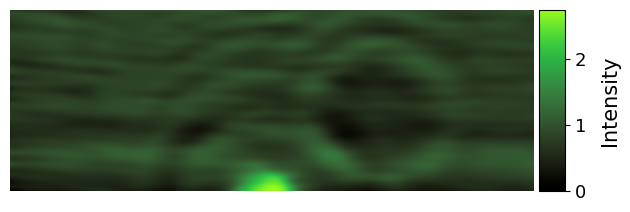

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x20789c00650>)

In [13]:

phase_shift = phase_map_ref - phase_map_im
phase_shift = np.mod(phase_shift, 2 * np.pi)  # modulo 2pi
phase_shift_crop = functions_phase_shift.crop_img_base(phase_shift, base_crop)  # crop base of the image
phase_shift_crop = utils.crop_lrt(phase_shift_crop, n=10)  # crops image left, right, top by 10 px to get rid of edge artefacts
image_unwrapped = functions_phase_shift.unwrap_phase_image(phase_shift_crop)
global_functions_im.plot_image(image_unwrapped)

rows, cols = image_unwrapped.shape
y0 = rows - 1  # bottom row of an image
x0 = cols // 2  # middle column of an image

mask_radius = 170
semicircle_mask = functions_abel.make_semicircle_mask((rows, cols),
                                                                  center=(y0, x0),
                                                                  radius=mask_radius,
                                                                  smooth_sigma=None)
#mask_flipped = 1 - semicircle_mask.astype(bool) # I need the outside
# fit polynomial - remove background
#bg, coeffs = functions_phase_shift.fit_plane_background(image_unwrapped, mask=mask_flipped)
bg, coeffs = functions_phase_shift.fit_plane_background(image_unwrapped)
image_unwrapped = image_unwrapped - bg
global_functions_im.plot_image(image_unwrapped)


image_unwrapped = functions_abel.normalize_image(image_unwrapped, force_zero=True)
global_functions_im.plot_image(image_unwrapped) # , cmap=cmr.gem

